In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
# from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [2]:
#提交样本
submission = pd.read_csv('sample_submission.csv')
# flow data
daily_data = pd.read_csv('./training_dataset/daily_dataset.csv')
hourly_data = pd.read_csv('./training_dataset/hourly_dataset.csv')
fivemin_data = pd.read_csv('./training_dataset/per5min_dataset.csv')
# other data
weather_data = pd.read_csv('./training_dataset/weather.csv')
epidemic_data = pd.read_csv('./training_dataset/epidemic.csv')
# 筛选训练数据
daily_train = daily_data[daily_data['train or test']=='train']
hourly_train = hourly_data[hourly_data['train or test']=='train']
fivemin_train = fivemin_data[fivemin_data['train or test']=='train']
weather_train = weather_data[weather_data['train or test']=='train']
epidemic_data = epidemic_data[epidemic_data['train or test']=='train']
hourly_train_new = hourly_train.reset_index(drop=True).copy()
hourly_train_new['day'] = hourly_train_new['time'].apply(lambda x:x[0:10])
cols = list(hourly_train_new.columns)[1:-2]
for each_col in cols:
    hourly_train_new[each_col] = hourly_train_new[each_col].apply(lambda x:x if x>0 else None)

In [3]:
first_part_timestamp = pd.Timestamp('2022-05-01 01:00:00')

In [4]:
hourly_train_new['datetime'] = hourly_train_new['time'].apply(lambda x:pd.Timestamp(x))
hourly_train_new = hourly_train_new[hourly_train_new['datetime']<first_part_timestamp]

# 异常值处理

In [5]:
import numpy as np

In [6]:
def time_window(x):
    x_value = x.values
    if len(x_value)>1:
        delta_time = (x_value[1] - x_value[0])/np.timedelta64(1, 'h')
        if delta_time>1:
            return list(x_value)
        else:
            return None
    else:
        return None

In [7]:
test_begin_list = []
test_begin_list.append(pd.Timestamp('2022-05-01 00:00:00'))
test_begin_list.append(pd.Timestamp('2022-06-01 00:00:00'))
test_begin_list.append(pd.Timestamp('2022-07-21 00:00:00'))

In [8]:
all_train_data = pd.DataFrame()
for each_col in cols:
    print(each_col)
    flow_col = hourly_train_new[['datetime', each_col]]
    flow_col_choose = flow_col.copy()
    flow_col_choose.index = flow_col['datetime']
    flow_col_choose = flow_col_choose[each_col].copy()
    flow_col_valid = flow_col[flow_col[each_col].notnull()].copy()
    time_delta = []
    for each_w in flow_col_valid['datetime'].rolling(window=2):
        if time_window(each_w):
            time_delta.append(time_window(each_w))
    time_delta_df = pd.DataFrame(time_delta)
    time_delta_df.columns = ['begin', 'end']
    time_delta_part = time_delta_df[~(time_delta_df['begin'].isin(test_begin_list))].reset_index(drop=True)
    print(time_delta_part)
    for row_num, each_row in time_delta_part.iterrows():
        interval_begin = each_row['begin']
        interval_end = each_row['end']
        null_df = flow_col_choose[interval_begin:interval_end]
        day_num = (interval_end-interval_begin).days     
        for each_index in null_df.index:
            if each_index<pd.Timestamp('2022-01-02'):
                index_after = each_index+datetime.timedelta(days=day_num+1, minutes=0, seconds=0)
                value_after = flow_col_choose[index_after]
                flow_col_choose[each_index] = value_after
            else:
                index_before = each_index-datetime.timedelta(days=day_num+1, minutes=0, seconds=0)
                value_before = flow_col_choose[index_before]
                flow_col_choose[each_index] = value_before
    all_train_data[each_col] = flow_col_choose

flow_1
                begin                 end
0 2022-04-24 06:00:00 2022-04-27 19:00:00
flow_2
                begin                 end
0 2022-04-24 10:00:00 2022-04-24 19:00:00
flow_3
                begin                 end
0 2022-04-24 06:00:00 2022-04-25 08:00:00
1 2022-04-30 06:00:00 2022-04-30 08:00:00
flow_4
                begin                 end
0 2022-04-24 06:00:00 2022-04-25 08:00:00
flow_5
                begin                 end
0 2022-01-06 08:00:00 2022-01-06 11:00:00
1 2022-01-09 08:00:00 2022-01-09 11:00:00
2 2022-03-25 15:00:00 2022-03-25 17:00:00
3 2022-04-24 06:00:00 2022-04-27 19:00:00
flow_6
                begin                 end
0 2022-04-24 06:00:00 2022-04-25 08:00:00
flow_7
                begin                 end
0 2022-01-26 14:00:00 2022-01-26 19:00:00
1 2022-03-28 18:00:00 2022-03-29 00:00:00
2 2022-04-12 00:00:00 2022-04-12 07:00:00
3 2022-04-14 00:00:00 2022-04-14 19:00:00
4 2022-04-24 06:00:00 2022-04-25 08:00:00
flow_8
                 beg

flow_1


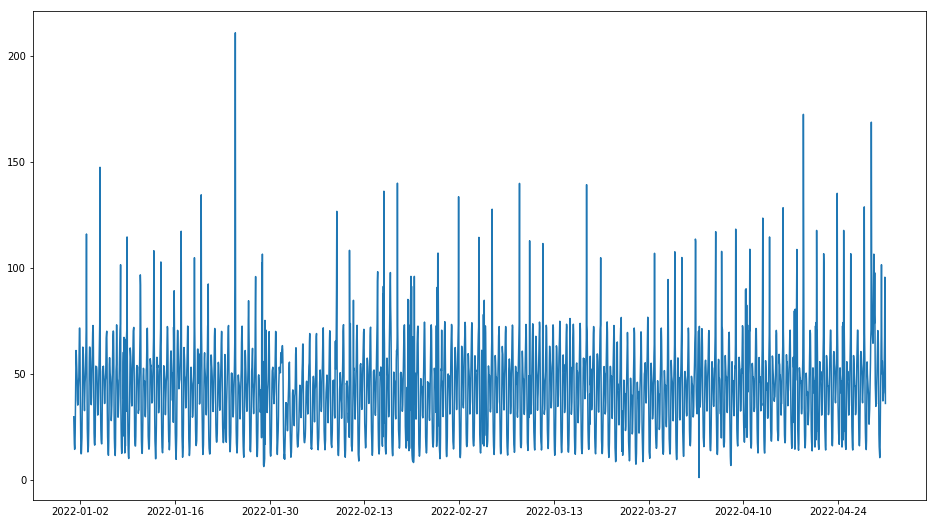

flow_2


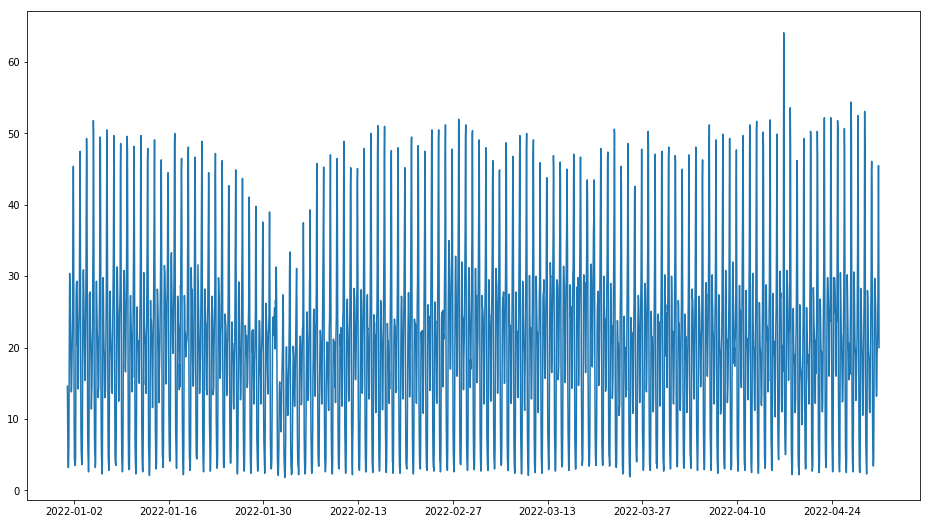

flow_3


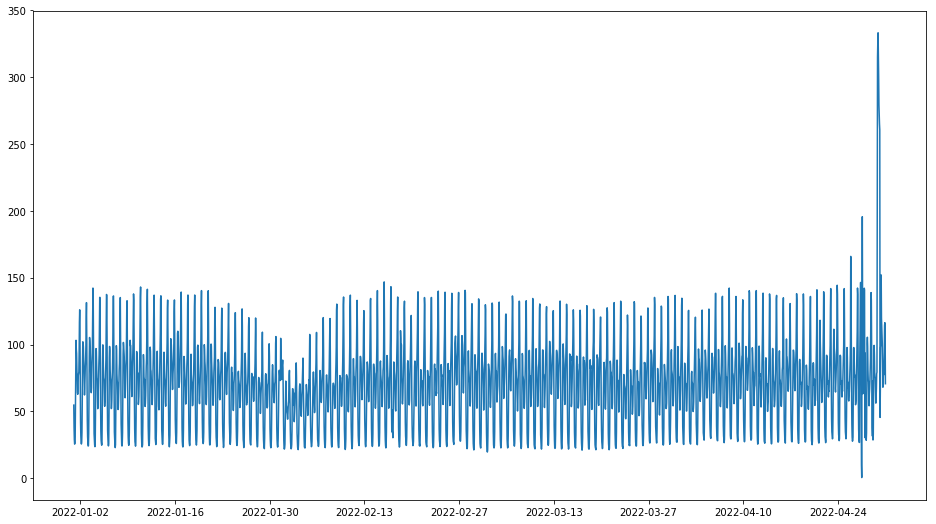

flow_4


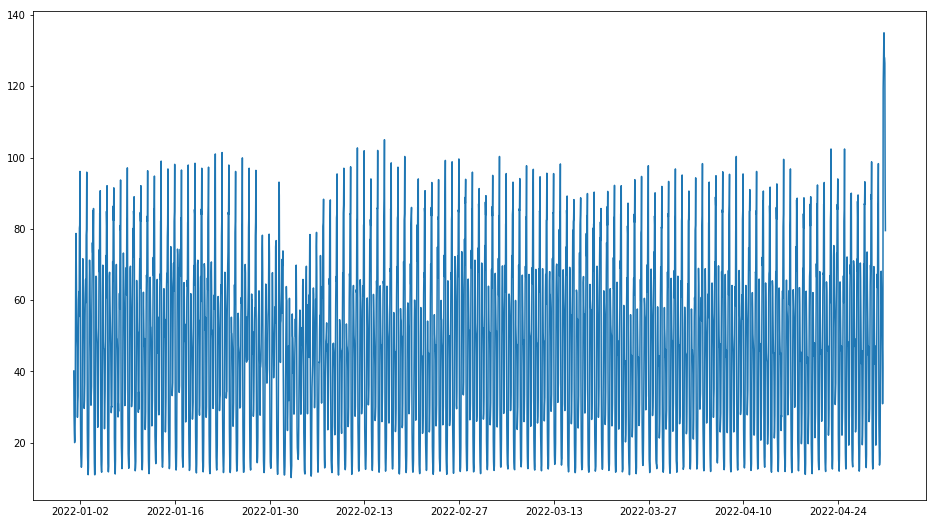

flow_5


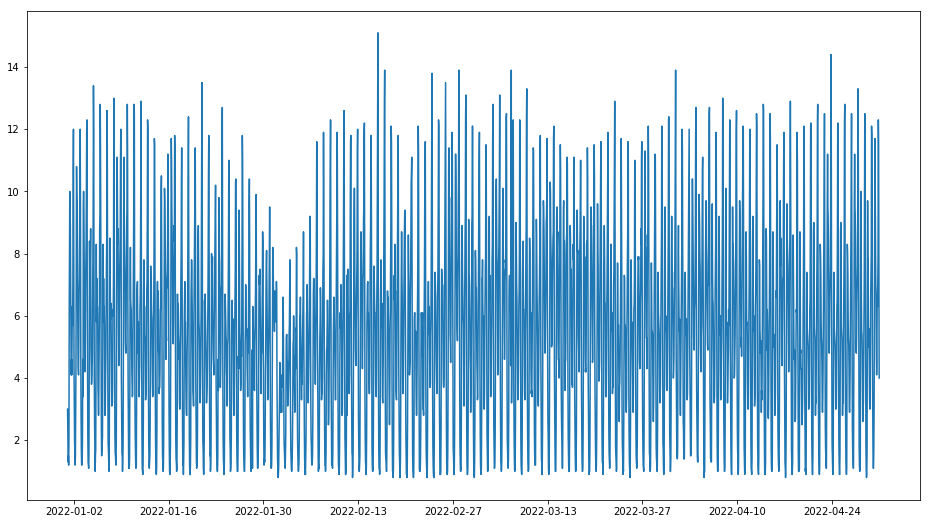

flow_6


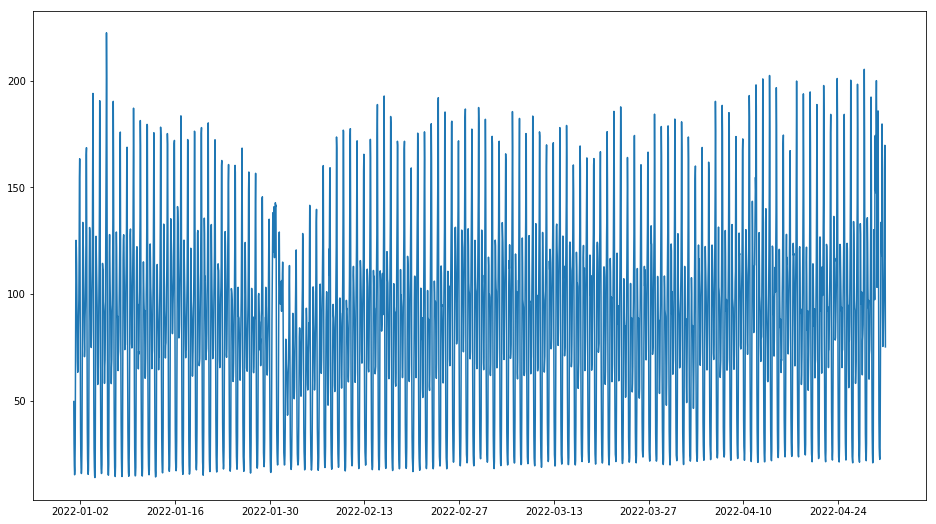

flow_7


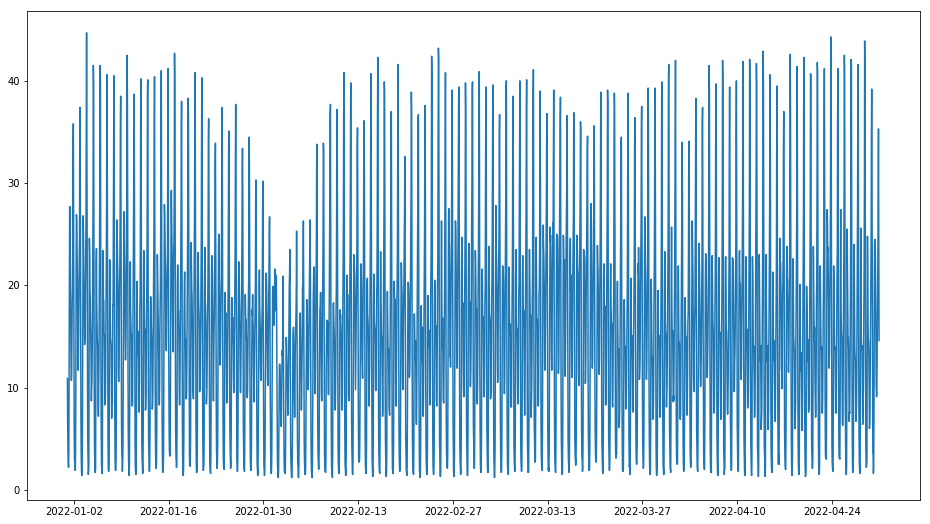

flow_8


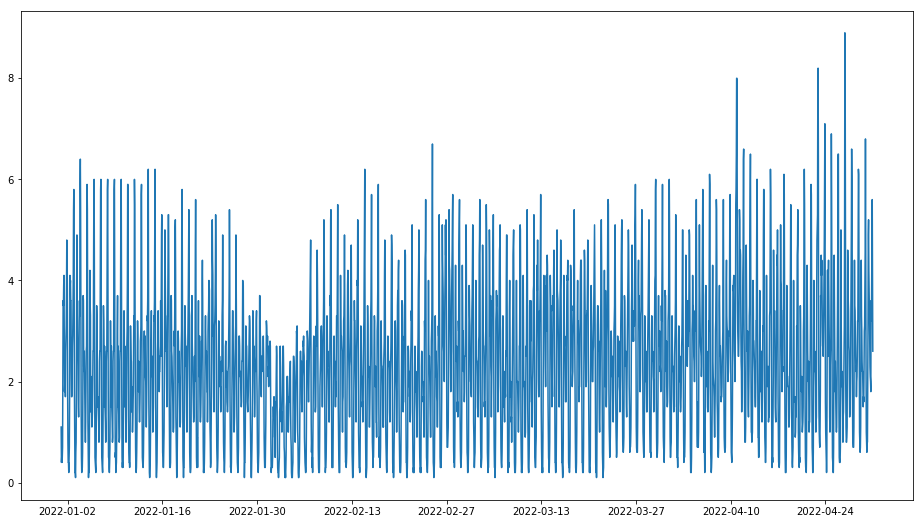

flow_9


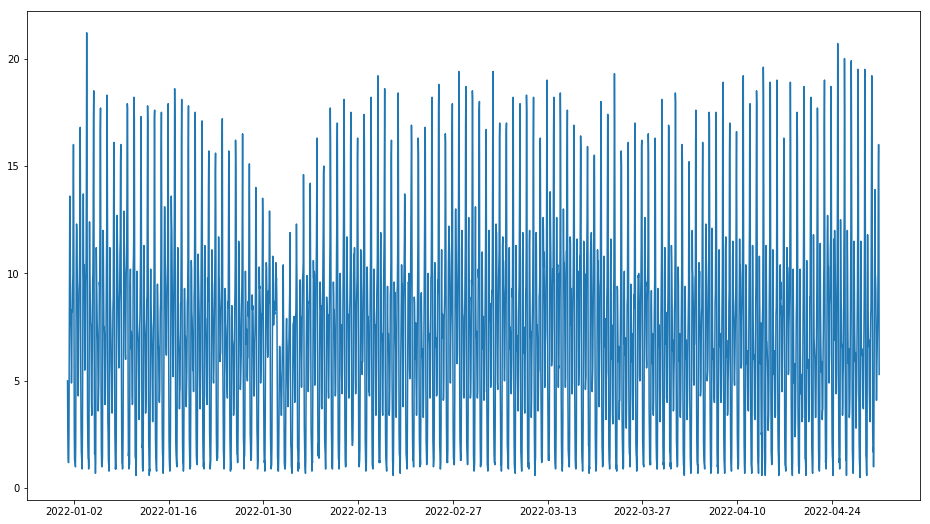

flow_10


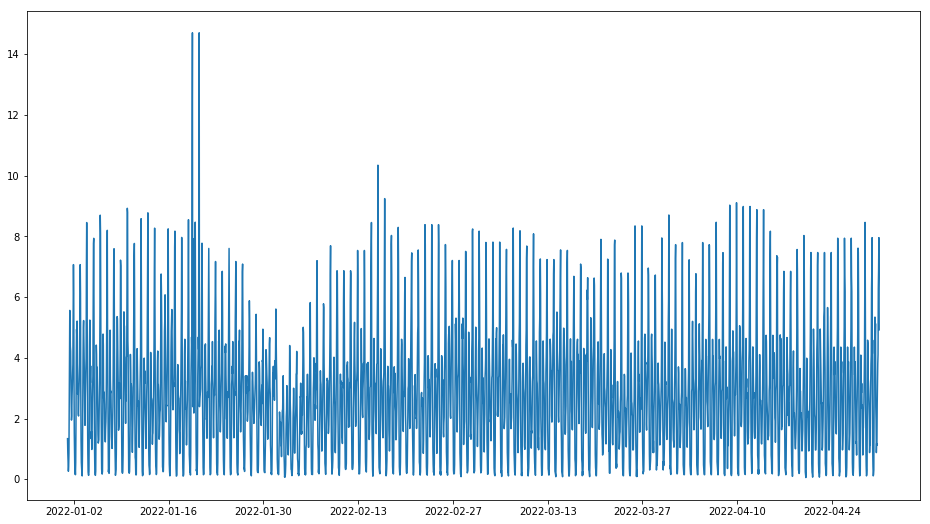

flow_11


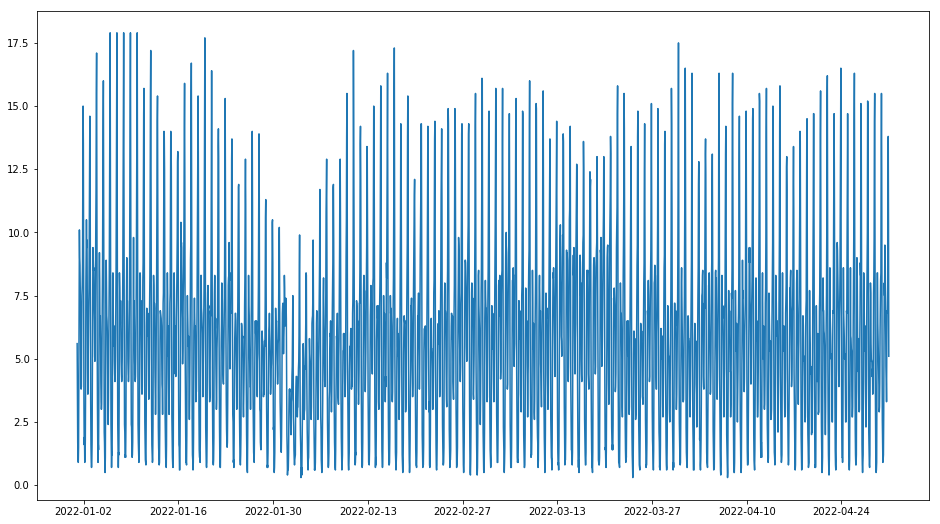

flow_12


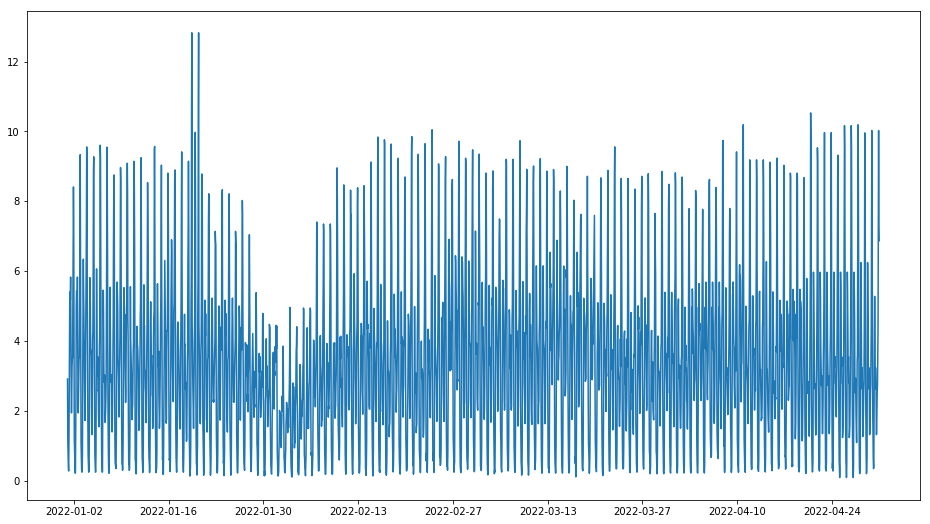

flow_13


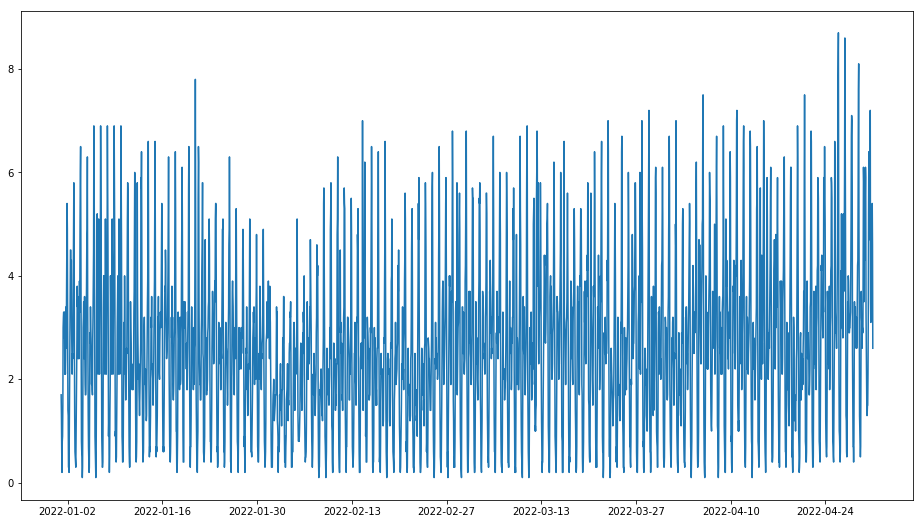

flow_14


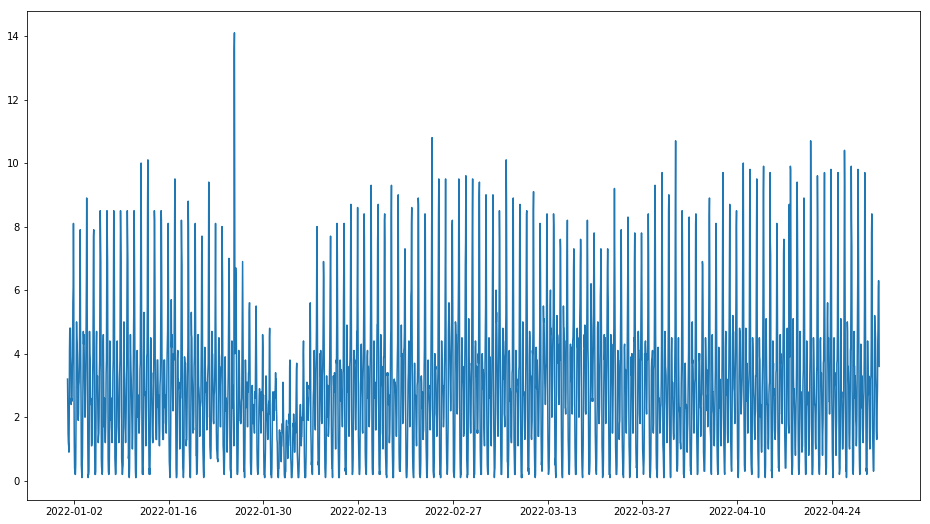

flow_15


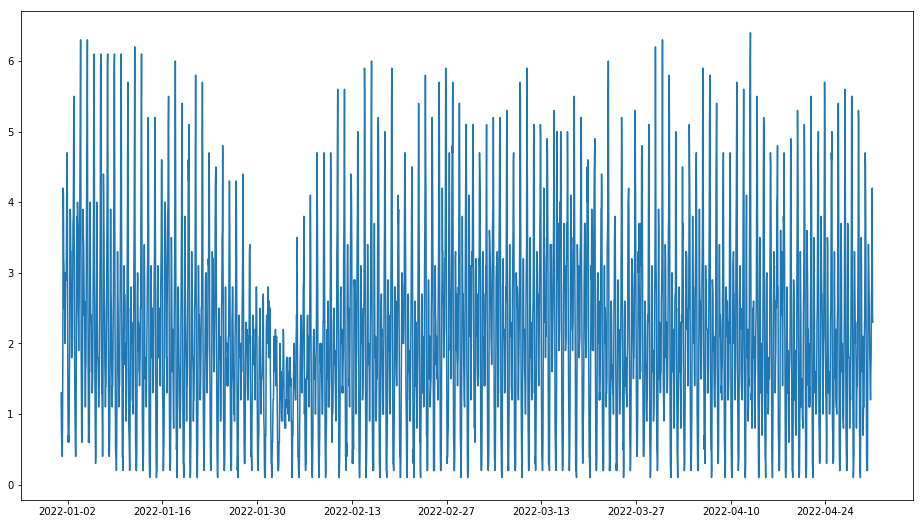

flow_16


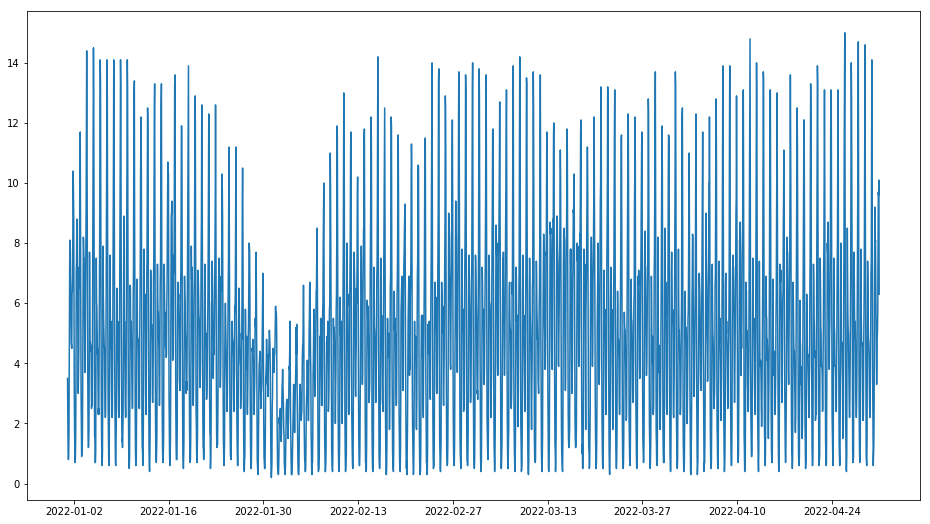

flow_17


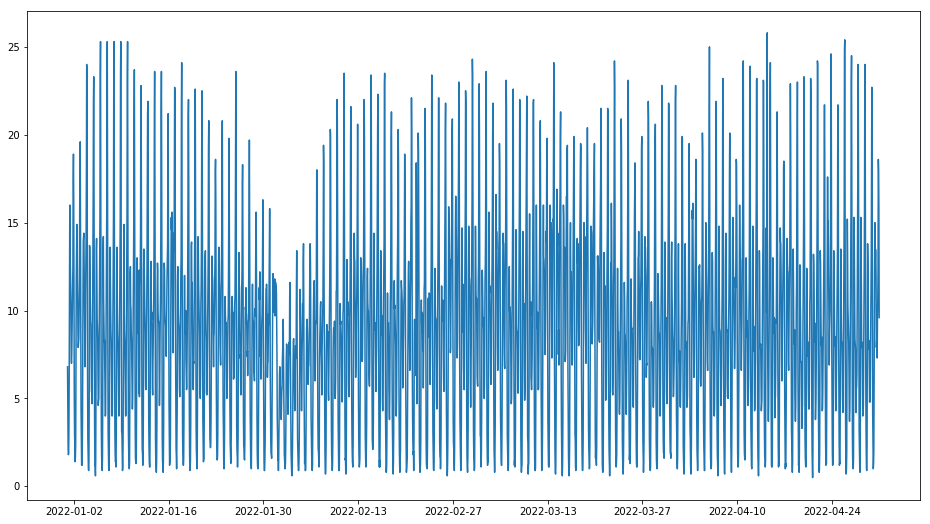

flow_18


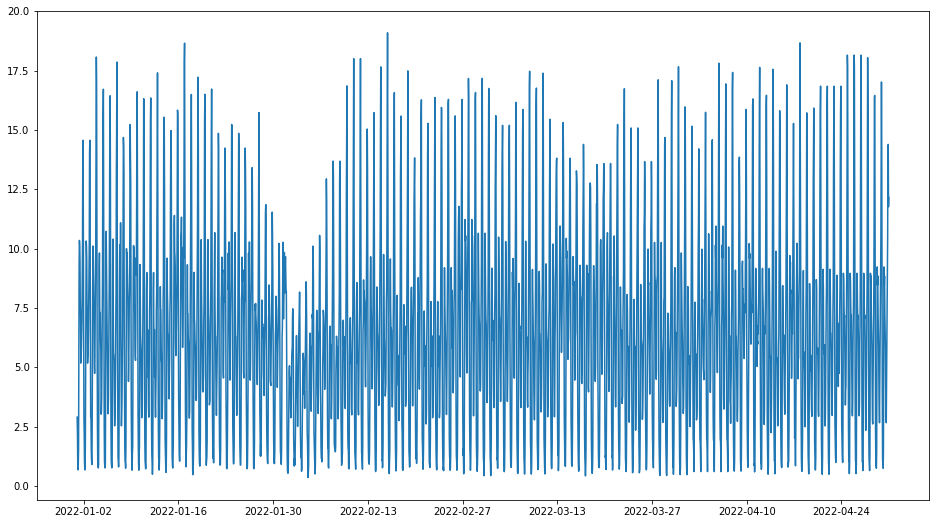

flow_19


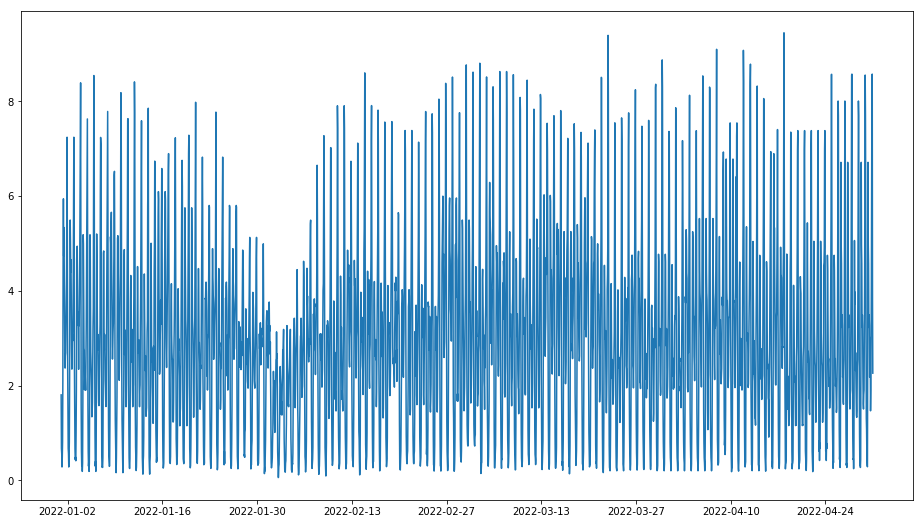

flow_20


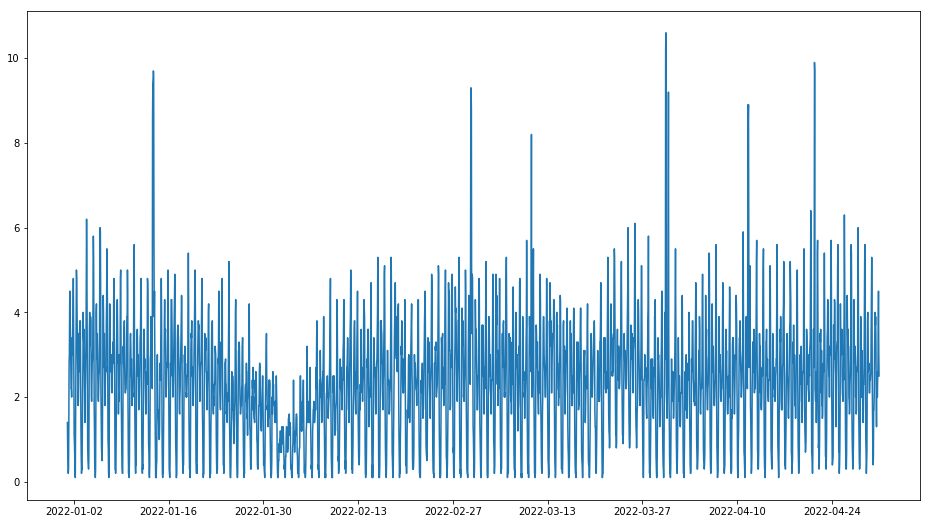

In [9]:
for each_col in cols:
    print(each_col)
    fig = plt.figure(figsize=(16,9))
    plt.plot(all_train_data[each_col])
    plt.show()

## 每个flow单独分析、处理和建模

### flow_1

### flow_2

In [ ]:
flow_two = hourly_train_new[['datetime', 'flow_2']].copy()
flow_two['flow_2'] = flow_two['flow_2'].apply(lambda x:x if x<100 else None)
flow_two.index = flow_two['datetime']
flow_two_all = flow_two['flow_2'].copy()
for each_index in flow_one_all[flow_one_all.isnull()].index:
    index_before = each_index-datetime.timedelta(days=3, minutes=0, seconds=0)
    index_after = each_index+datetime.timedelta(days=4, minutes=0, seconds=0)
    value_before = flow_one_all[index_before]
    flow_one_all[each_index] = value_before

In [14]:
# Prophet
# 分段预测
end_date = pd.Timestamp('2022-04-25 00:00:00')
test_begin = pd.Timestamp('2022-04-25 00:00:00')
test_end = pd.Timestamp('2022-05-01 01:00:00')
flow_one_train = flow_one_all[:end_date]
test_index_one = pd.date_range(start='2022-04-25',end='2022-05-01',freq='H')
flow_one_test = pd.Series(index=test_index_one, dtype='float64')
fh = ForecastingHorizon(flow_one_test.index, is_relative=False)
y_test = flow_one_all[test_begin:test_end]
forecaster = Prophet(
    seasonality_mode="additive",
    n_changepoints=int(len(flow_one_train) / 24),
    weekly_seasonality=True,
    daily_seasonality=True
)

forecaster.fit(flow_one_train)
y_pred = forecaster.predict(fh)
y_pred

plot_series(flow_one_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

ModuleNotFoundError: Prophet requires package 'prophet' to be present in the python environment, but 'prophet' was not found. 'prophet' is a soft dependency and not included in the base sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[all_extras]`

In [8]:
test_index = pd.date_range(start='2022-05-01',end='2022-05-08',freq='H')
flow_one_test = pd.Series(index=test_index, dtype='float64')
fh = ForecastingHorizon(flow_one_test.index, is_relative=False)

In [10]:
forecaster = Prophet(
    seasonality_mode="additive",
    n_changepoints=int(len(flow_one_train) / 7),
    weekly_seasonality=True,
    daily_seasonality=True
)

forecaster.fit(flow_one_train)
y_pred = forecaster.predict(fh)
y_pred
y_pred.index = flow_one_test.index

# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing


2022-05-01 00:00:00    38.931501
2022-05-01 01:00:00    22.821602
2022-05-01 02:00:00    13.204590
2022-05-01 03:00:00    10.523243
2022-05-01 04:00:00    12.878541
                         ...    
2022-05-07 20:00:00    68.770803
2022-05-07 21:00:00    74.557821
2022-05-07 22:00:00    70.305934
2022-05-07 23:00:00    56.438524
2022-05-08 00:00:00    38.123603
Length: 169, dtype: float64

flow_1


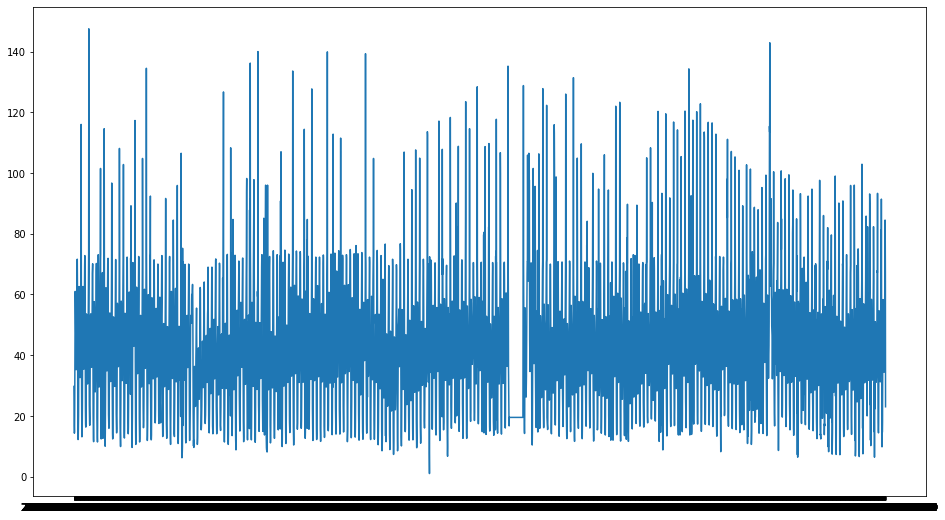

flow_2


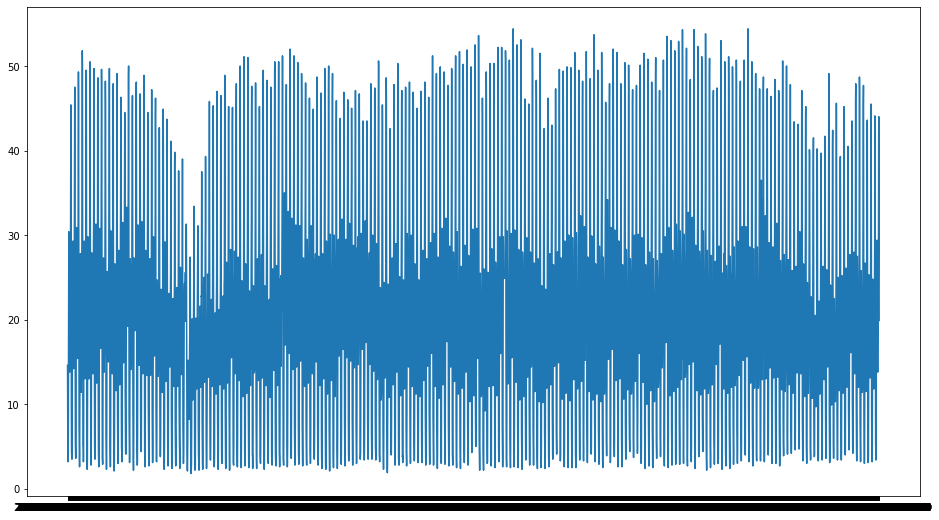

flow_3


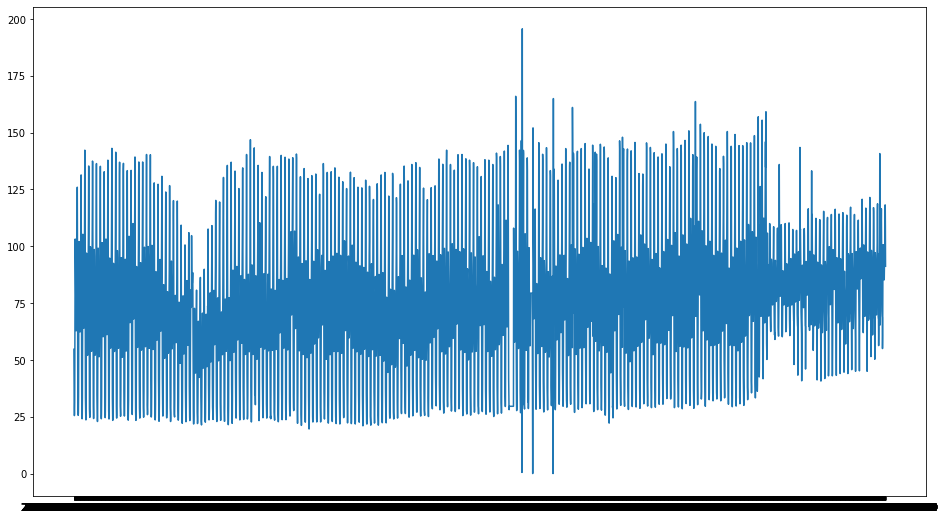

flow_4


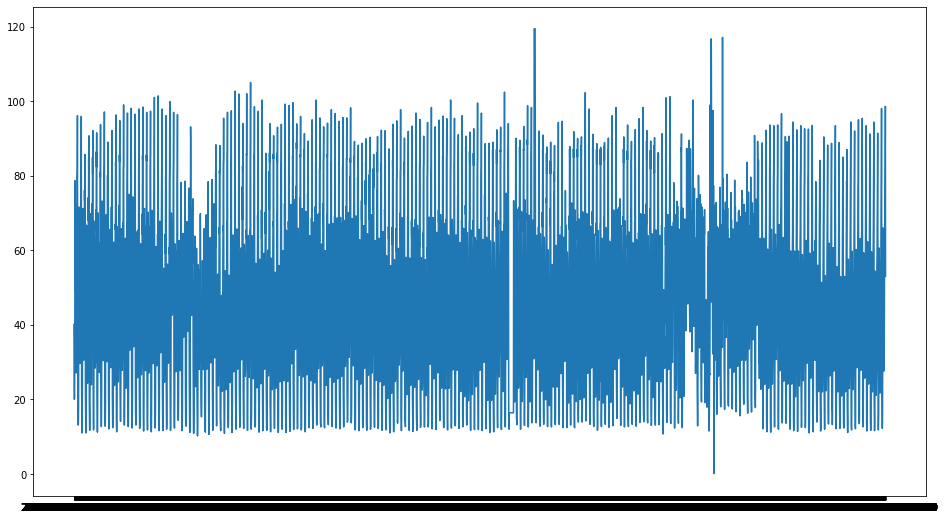

flow_5


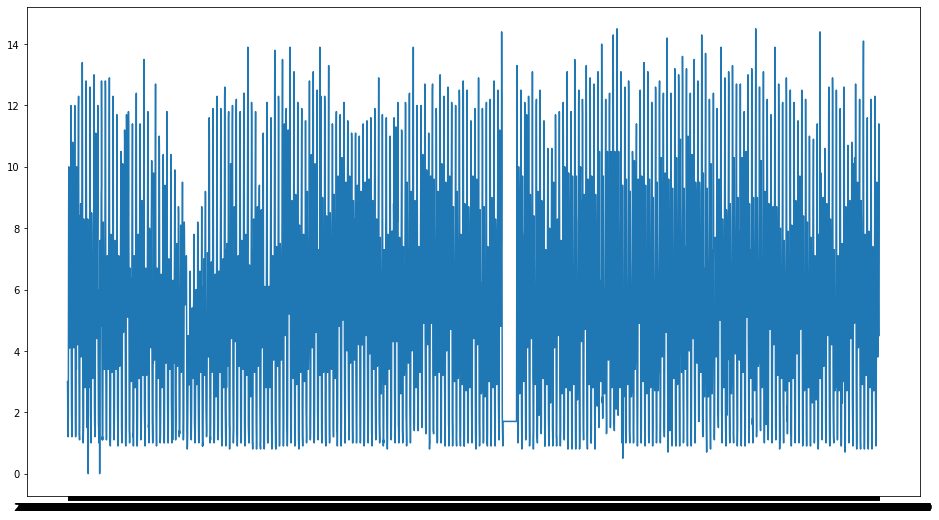

flow_6


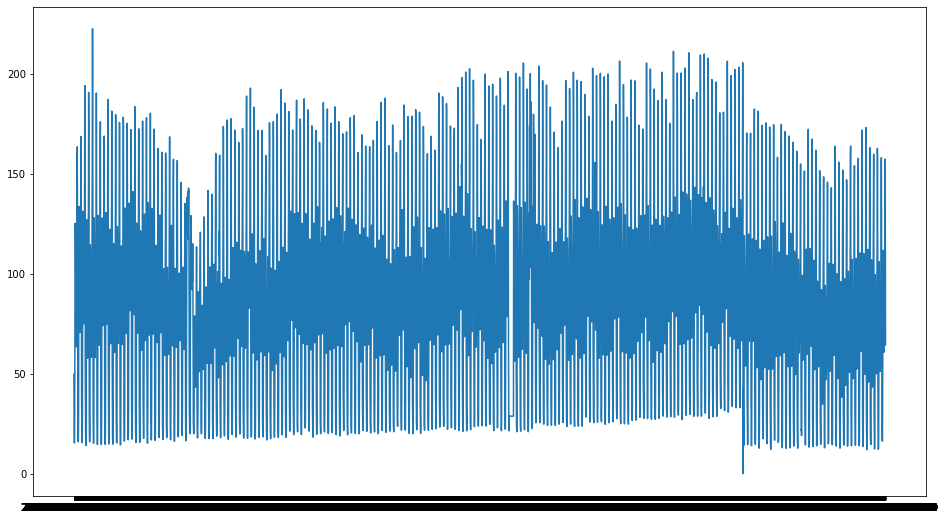

flow_7


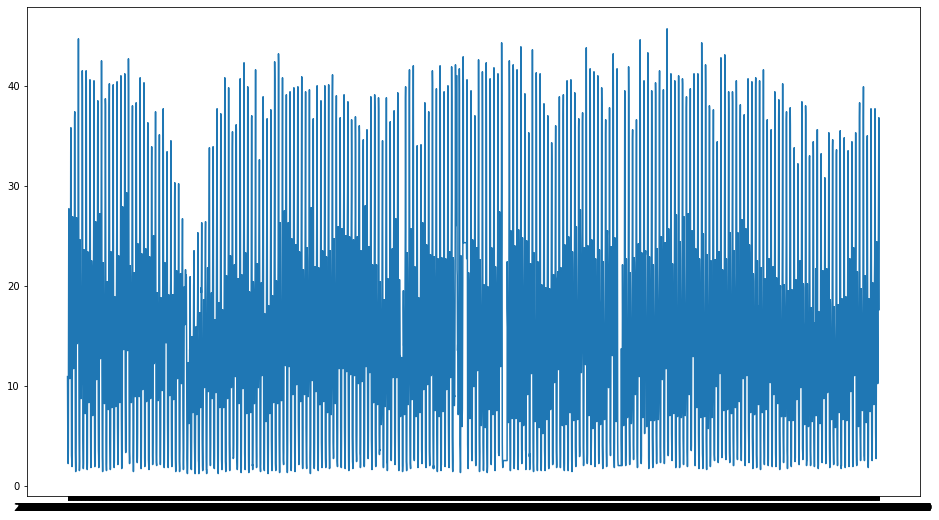

flow_8


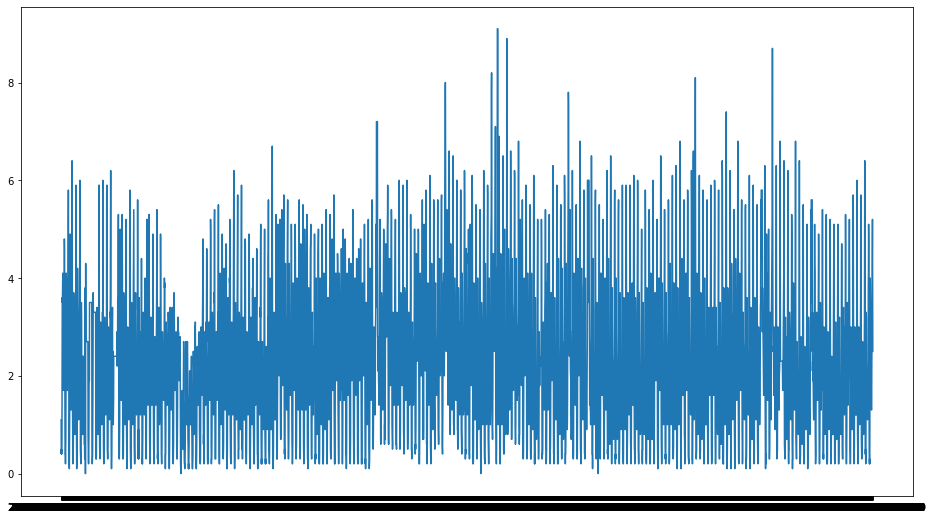

flow_9


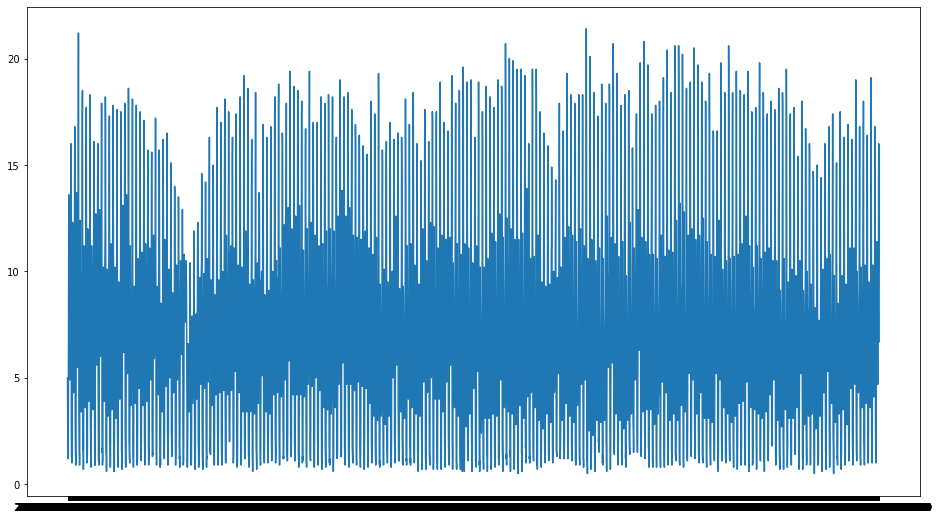

flow_10


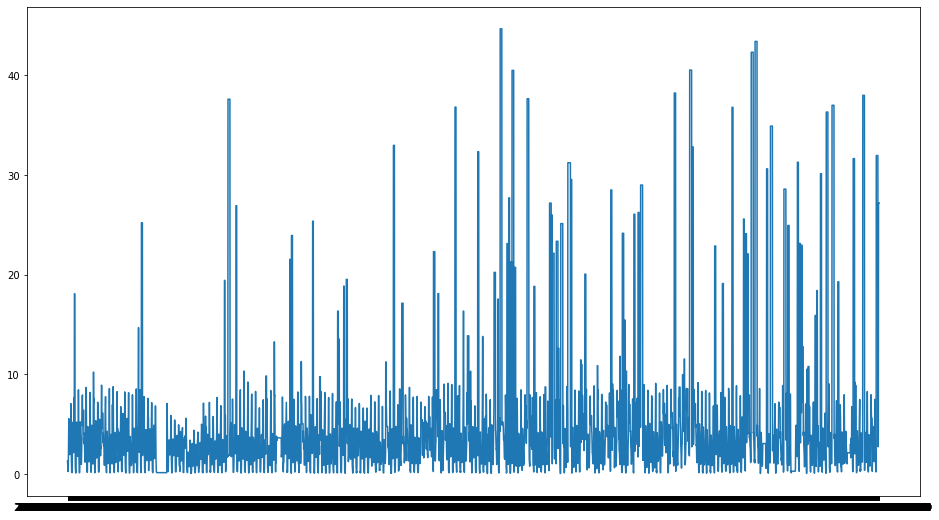

flow_11


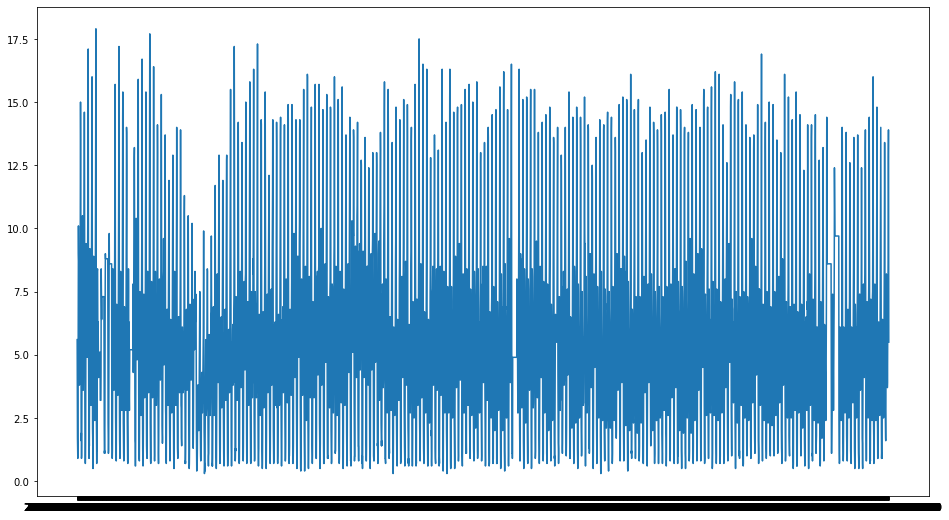

flow_12


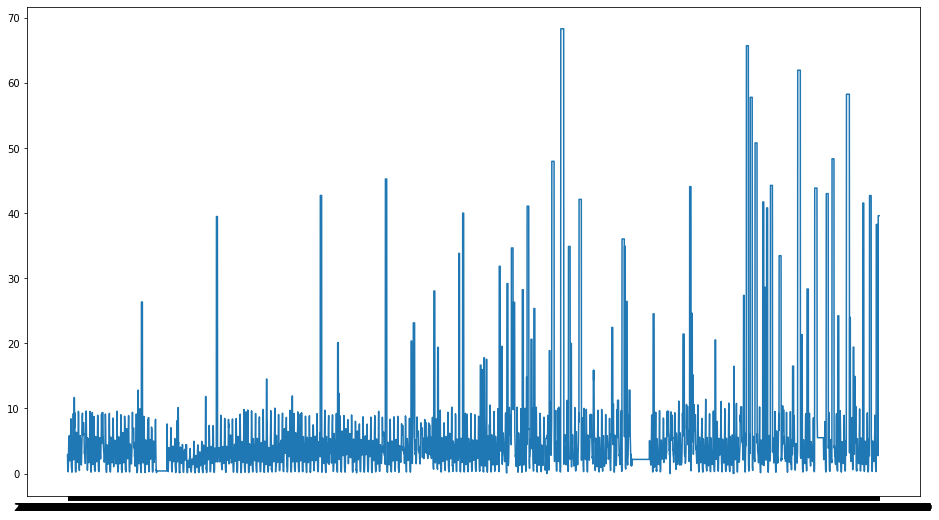

flow_13


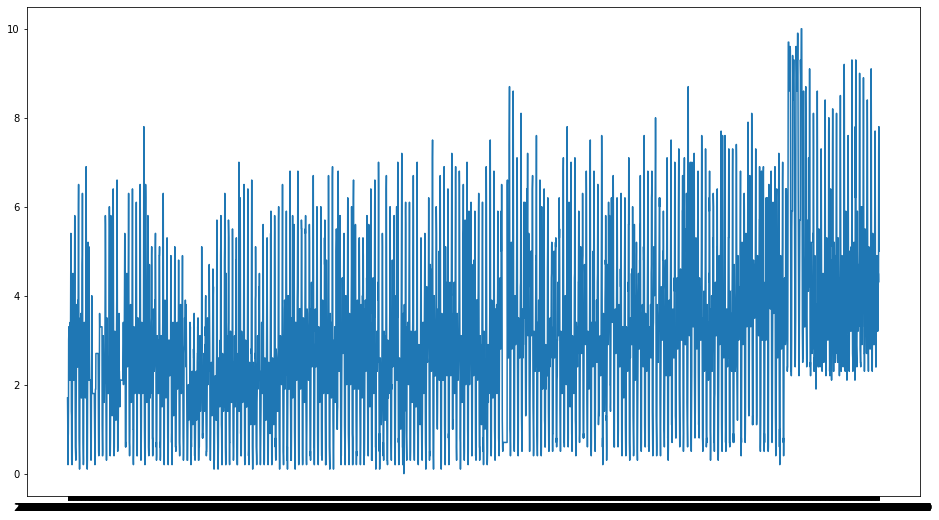

flow_14


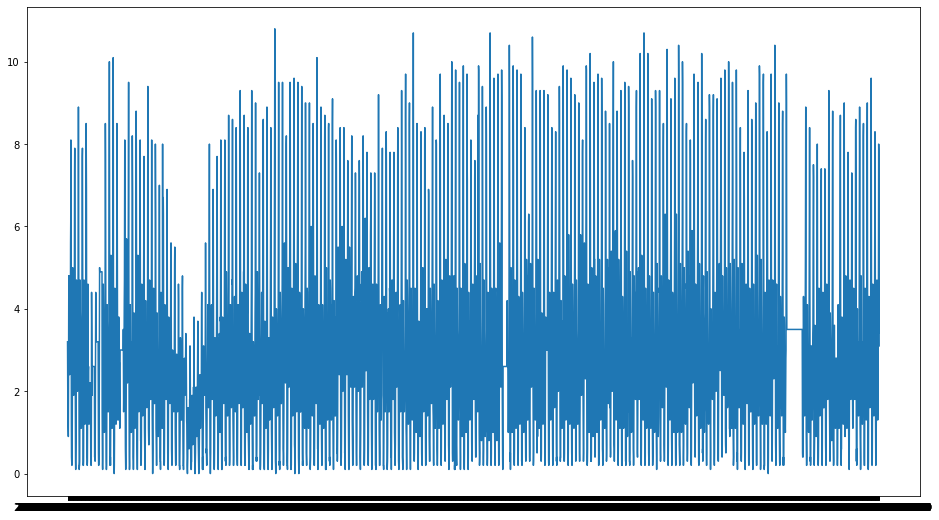

flow_15


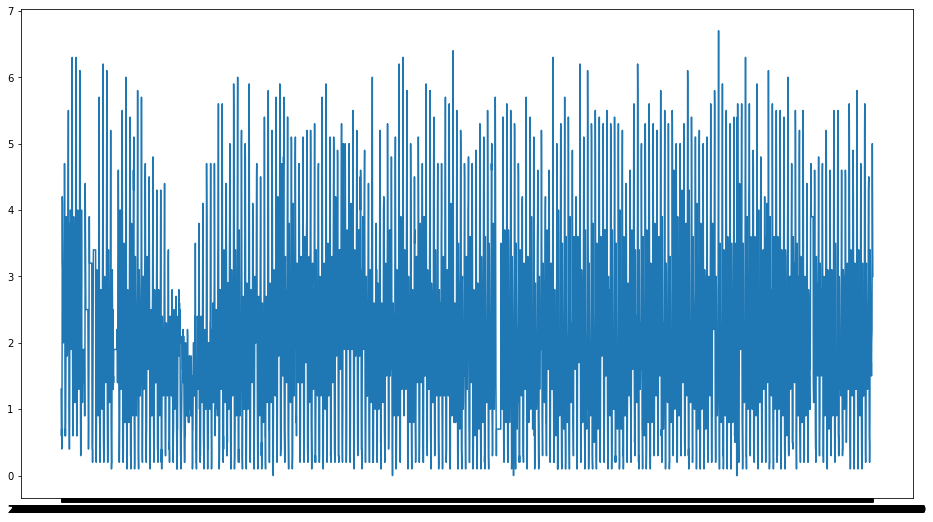

flow_16


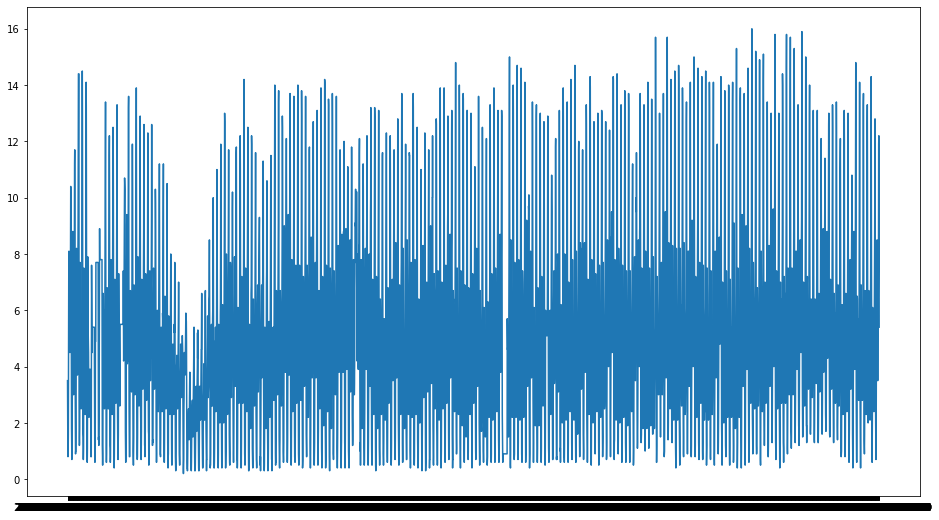

flow_17


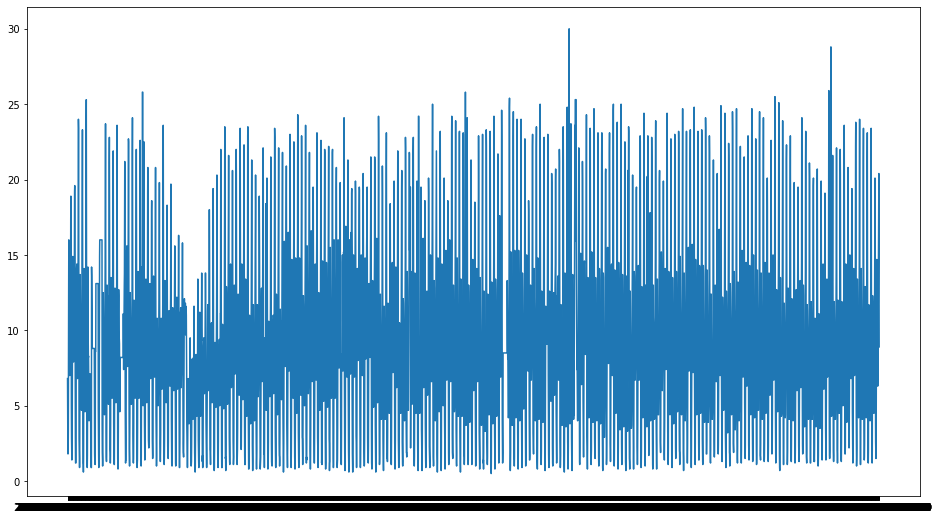

flow_18


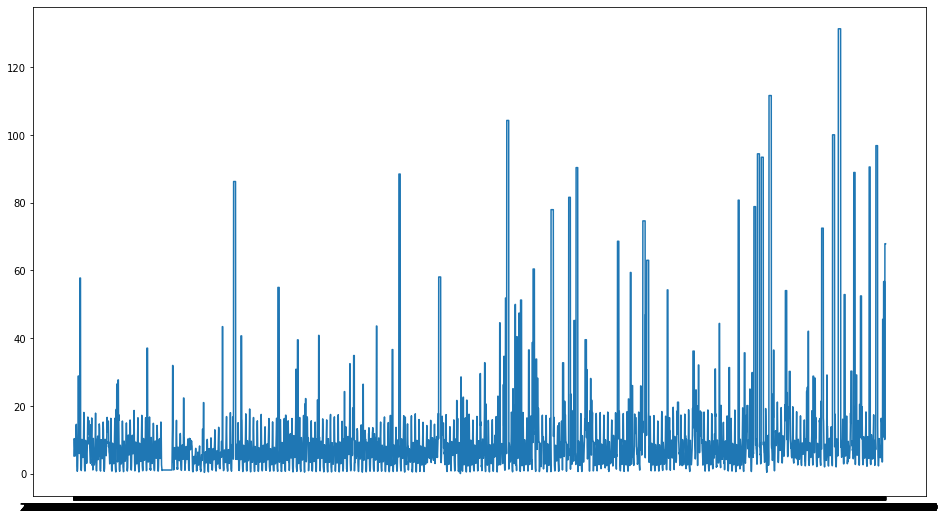

flow_19


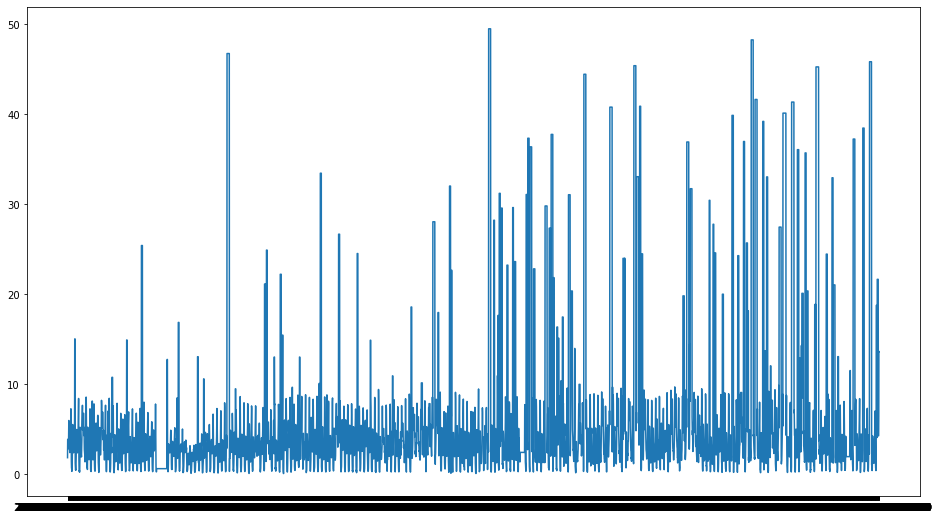

flow_20


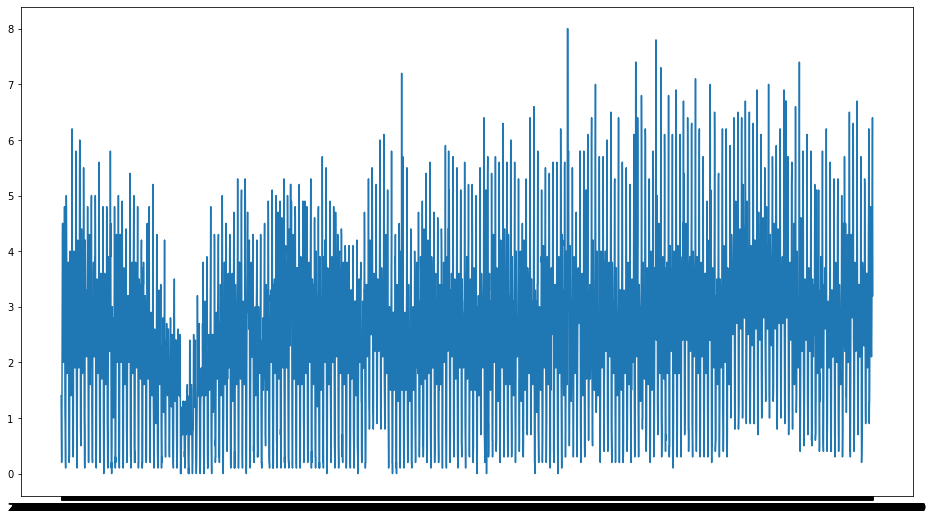

In [8]:
# plot
for each_col in cols:
    print(each_col)
    fig = plt.figure(figsize=(16,9))
    plt.plot(list(hourly_train_new['time']),list(hourly_train_new[each_col]))
    plt.show()